In [39]:
# coding:utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import chainer
from chainer import Function, Variable, optimizers
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L
import copy
"""
MAZE = [[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
        [-1,-1,-1,-1,-1, 0,-1,-1, 0,-1],
        [-1,-1, 0, 0, 0, 0, 0,-1, 0,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1],
        [-1, 0,-1, 0, 0, 0, 0, 0, 0,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0, 0,-1],
        [-1,-1, 0,-1,-1,-1,-1,-1,-9,-1],
        [-1,-1, 0, 0, 0, 0, 0, 0, 1,-1],
        [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]
"""
MAZE = [[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1],
        [-1,-1,-1,-1,-1, 0,-1,-1, 0,-1,-1,-1],
        [-1,-1, 0, 0, 0, 0, 0,-1, 0,-1,-1,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1,-1,-1],
        [-1, 0, 0, 0, 0, 0, 0, 0 ,0,-1,-1,-1],
        [-1, 0,-1,-1,-1,-1,-1,-1, 0,-1,-1,-1],
        [ 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1],
        [ 0,-1, 0,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [ 0,-1, 0, 0, 0, 0, 0, 0, 0,-1,-1,-1],
        [ 0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
        [ 0,-1, 0, 0, 0, 0,-1, 0, 0, 0, 1,-1],
        [ 0, 0, 0,-1,-1, 0, 0, 0,-1,-1,-1,-1]]
START  = (1, 1)
ACTION = [(-1, 0), (1, 0), (0, -1), (0, 1)] # [上, 下, 左, 右]
EPOCH  = 10
RESULT = []
NUM_IN   = (len(MAZE)+1) * (len(MAZE[0])+1)
NUM_HID1 = 450
NUM_HID2 = 250
NUM_HID3 = 100
NUM_OUT  = 4
BATCH_SIZE = 100
ALPH   = 0.1
EPSIL  = 0.1
GAMMA  = np.array([0.99 for i in range(BATCH_SIZE)], np.float32)


def q_learn(q_network, target_network, records):
    f = open("/Users/chan-p/Desktop/action.txt", "w")
    result_list = []
    state_index = init_index()
    state_vecs, actions, rewords ,next_state_vecs, terminals = translate(records)
    next_records = []
    best_records = []
    for epoch in range(EPOCH):
        state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
        now_state = START
        state_vec[state_index[START]] = 1
        f.write(str(0) + "," + str(0) + "," +str(3) + "\n")
        while True:
            # 状態sをDNN用にベクトル化
            state_vec = np.array([state_vec], dtype = np.float32)
            # 状態sをDNNの入力として状態sにおける各行動aの行動価値を算出：Q(s,a)
            # 方策：e-greedy
            action, q_max, action_list = policy_egreedy(state_vec, q_network)
            # 次の状態s'を決定
            next_state = (now_state[0]+action[0], now_state[1]+action[1])
            # 即時報酬
            # 次の状態が迷路外ならエピソード終了
            if state_check(next_state) == 0:
                f.write(str(action[0]) + "," + str(action[1]) + "," +str(1) + "\n")
                next_records.append((now_state, action, -1, 1))
                result_list.append(0)
                break
            reword = MAZE[next_state[0]][next_state[1]]
            if reword == 1:
                print(epoch)
                f.write(str(0) + "," + str(0) + "," +str(2) + "\n")
                best_records.append((now_state, action, 1, 1))
                result_list.append(1)
                break
            next_records.append((now_state, action, reword/2, 0))
            next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
            next_state_vec[state_index[next_state]] = 1
            f.write(str(action[0]) + "," + str(action[1]) + "," +str(0) + "\n")
            next_actions = target_network.forward(0, np.array([next_state_vec], dtype=np.float32))
            y_target = reword_vectrize(next_state) + np.array([0.99 for i in range(4)]) * np.array(next_actions.data[0])
            y_target = np.array([ALPH for i in range(4)]) * (y_target - target_network.forward(0, x_batch_next_state))
            now_state = next_state
                                    
            # 学習
            # experiment_replayによるバッチ学習
            perm = np.random.permutation(len(records))[:BATCH_SIZE]
            x_batch_state   = state_vecs[perm[0:BATCH_SIZE]]
            x_batch_action  = actions[perm[0:BATCH_SIZE]]
            x_batch_rewords = rewords[perm[0:BATCH_SIZE]]
            x_batch_next_state = next_state_vecs[perm[0:BATCH_SIZE]]
            # ニューラルの重み更新
            q_network.init_grads()
            next_actions = target_network.forward(0, x_batch_next_state)
            max_q = np.max(next_actions.data, axis = 1)
            y_batch_targets = x_batch_rewords + GAMMA * max_q
            loss = q_network.forward(1, x_batch_state, y_batch_targets)
            q_network.backpropagation(loss)
        # レコードの更新
        if len(next_records) + len(best_records) > 1000:
            if len(best_records) > 500:
                best_records = []
            next_records.extend(best_records)
            state_vecs, actions, rewords ,next_state_vecs, terminals = translate(next_records)
            records = next_records
            next_records = []
        # target networkの更新
        if epoch % 1 == 0:
            target_network = update_target_network(q_network, target_network)
    # output_qtable(target_network, state_index)
    return result_list

def update_target_network(q_network, target_network):
    # target_network = copy.deepcopy(q_network)
    return q_network
        
    
def policy_egreedy(state, neural):
    qvalue = neural.forward(0, state).data[0]
    return (ACTION[random.choice([i for i, x in enumerate(qvalue) if x == max(qvalue)])] if EPSIL < random.random() else random.choice(ACTION)), max(qvalue), qvalue           
    

def reword_vectrize(next_state):
    next_reword = []
    for action in ACTION:
        if  (next_state[0] + action[0]) < 0 or (next_state[0] + action[0]) > 10 or (next_state[1] + action[1]) > 9 or (next_state[1] + action[1]) < 0:
            next_reword.append(-1)
        else:
            next_reword.append(MAZE[(next_state[0] + action[0])][(next_state[1] + action[1])])
    # print("reword："+str(next_reword))
    return np.array(next_reword, dtype = np.float32)
    
    
def state_check(state):
    if (state[0] < 0) or (state[1] < 0) or (len(MAZE)-1) < state[0] or (len(MAZE[0])-1 < state[1]) :
        RESULT.append(0)
        return 0
    return 1                          

def init_qtable():
    qtable_index = {}
    num = 0
    for y in range(len(MAZE)+1):
        for x in range(len(MAZE[0])+1):
            qtable_index[(y, x)] = num
            num += 1
    return qtable_index

def init_index():
    qtable_index = {}
    num = 0
    for y in range(len(MAZE)+1):
        for x in range(len(MAZE[0])+1):
            qtable_index[(y, x)] = num
            num += 1
    return qtable_index

def experience_replay():
    records = []
    with open("./record.csv") as f:
        for line in f:
            line   = line[:-1].split(",")
            state  = (int(line[0]), int(line[1]))
            action = (int(line[2]), int(line[3]))
            reword = int(line[4])
            terminal = int(line[5])
            record = (state, action, reword, terminal)
            records.append(record)
    return records

def translate(records):
    state_vecs  = []
    actions = []
    rewords = []
    terminals = []
    next_state_vecs = []
    state_index = init_index()
    state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
    next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
    for record in records:
        next_state = (record[0][0]+record[1][0], record[0][1]+record[1][1])
        state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
        state_vec[state_index[record[0]]] = 1
        state_vecs.append(state_vec)
        actions.append(record[1])
        rewords.append(record[2])
        terminals.append(record[3])
        if record[3] == 1:
            next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
            next_state_vecs.append(next_state_vec)
        else:
            next_state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
            next_state_vec[state_index[next_state]] = 1
            next_state_vecs.append(next_state_vec)
    return np.array(state_vecs, dtype=np.float32), np.array(actions), np.array(rewords, dtype=np.float32), np.array(next_state_vecs, dtype=np.float32), np.array(terminals, dtype=np.float32)
    

def state_check(state):
    if state[0] < 0 or state[1] < 0 or 10 < state[0] or 9 < state[1] :
        return 0
    return 1

def output_qtable(q_network, state_index):
    state_index = {v:k for k, v in state_index.items()}
    for index in range(NUM_IN):
        state_vec = np.array([0 for i in range(NUM_IN)], dtype=np.float32)
        state_vec[index] = 1
        state_vec = np.array([state_vec], dtype = np.float32)
        q_value = q_network.forward(0, state_vec)
        print(str(state_index[index]) + "：" + str(q_value.data[0]))

def main():
    q_network = neuralnetwork(NUM_IN, NUM_HID1, NUM_HID2, NUM_HID3, NUM_OUT)
    target_network = update_target_network(q_network, neuralnetwork(NUM_IN, NUM_HID1, NUM_HID2, NUM_HID3, NUM_OUT))
    return q_learn(q_network, target_network, experience_replay())
    

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def gragh(result, epoch):    
    x = np.arange(0, epoch, 1)
    left = np.array(x)
    count = 0
    count_1 = 0
    parcent = []
    for i in result:
        count += 1
        if i == 1:
            count_1 += 1
        parcent.append(count_1/count)
    print(parcent[-1])
    height = np.array(parcent)
    plt.plot(left, height)

0.0


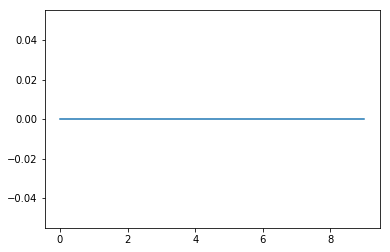

In [40]:
_list = main()
gragh(_list, len(_list))

In [5]:
import chainer
from chainer import Function, Variable, optimizers
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L

class neuralnetwork:
    def __init__(self, num_in, num_hid1, num_hid2, num_hid3, num_out):
        self.model = Chain(hid_layer1 = L.Linear(num_in, num_hid1),
                           hid_layer2 = L.Linear(num_hid1, num_hid2),
                           hid_layer3 = L.Linear(num_hid2, num_hid3),
                           out_layer  = L.Linear(num_hid3, num_out))
        self.optimizer = optimizers.Adam()
        self.optimizer.setup(self.model)
    
    def forward(self, flg, x, t = None):
        _x = Variable(x)
        if flg == 1: _t = Variable(t)
        h1  = F.dropout(F.relu(self.model.hid_layer1(_x)))
        h2  = F.dropout(F.relu(self.model.hid_layer2(h1)))
        h3  = F.dropout(F.relu(self.model.hid_layer3(h2)))
        u3  = self.model.out_layer(h3)
        # return F.softmax_cross_entropy(u2, _t) if flg else F.softmax(u2)
        return F.mean_squared_error(self.policy_greedy(u3), _t) if flg else u3
    
    def backpropagation(self, loss):
        loss.backward()
        self.optimizer.update()
    
    def init_grads(self):
        self.optimizer.zero_grads()
        
    def policy_greedy(self, actions):
        return np.max(actions.data, axis = 1)


In [60]:
# -*- coding: utf-8 -*-
import numpy as np
import chainer
from chainer import Function, Variable, optimizers
from chainer import Link, Chain
import chainer.functions as F
import chainer.links as L
import random
import traceback
import sys
import math

#5次元のベクトルを入力して、そのベクトルがYes(1)かNo(0)かの2値分類
#3層パーセプトロン
model =  Chain(Hidden_Layer=L.Linear(5,13),Output_Layer=L.Linear(13,2))
#最適化アルゴリズム：SGD
optimizer = optimizers.Adam()
optimizer.setup(model)
print(model)
p = np.array([0.2,0.5,0.1,0.2,0.1],dtype=np.float32)
Input = np.array([p, p],dtype=np.float32)
print(Input)
X = Variable(Input)
u1 = model.Hidden_Layer(X)
h = F.relu(u1)
u2 = model.Output_Layer(h)
y = u2
print("as:"+str(y.data))
Answer1 = np.array([2.0, 1.1],dtype=np.float32)
asd = []
asd.append(Answer1)
asd.append(Answer1)
Answer = np.array(asd, dtype=np.float32)
T = Variable(Answer)

for roop in range(10):
    optimizer.zero_grads()

    u1 = model.Hidden_Layer(X)
    h = F.relu(u1)
    u2 = model.Output_Layer(h)
    y = u2
    print(y.data)
    print(T.data)
    # loss = F.softmax_cross_entropy(u2,T)
    loss = F.mean_squared_error(y,T)
    loss.backward()
    optimizer.weight_decay(0.8)
    optimizer.update()


p = np.array([0.22,0.13,0.99,0.3,0.2],dtype=np.float32)
Input = np.array([p],dtype=np.float32)
X = Variable(Input)


u1 = model.Hidden_Layer(X)
h = F.relu(u1)
u2 = model.Output_Layer(h)
y = u2
print("unknown" + str(y.data))



[[ 0.2  0.5  0.1  0.2  0.1]
 [ 0.2  0.5  0.1  0.2  0.1]]
as:[[ 0.09639793  0.00071677]
 [ 0.09639793  0.00071677]]
[[ 0.09639793  0.00071677]
 [ 0.09639793  0.00071677]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.10044377  0.0038343 ]
 [ 0.10044377  0.0038343 ]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.10449059  0.00695183]
 [ 0.10449059  0.00695183]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.10853845  0.01006872]
 [ 0.10853845  0.01006872]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.11258755  0.01318443]
 [ 0.11258755  0.01318443]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.11663818  0.01629826]
 [ 0.11663818  0.01629826]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.12069059  0.01940953]
 [ 0.12069059  0.01940953]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.1247453   0.02251755]
 [ 0.1247453   0.02251755]]
[[ 2.          1.10000002]
 [ 2.          1.10000002]]
[[ 0.